<a href="https://colab.research.google.com/github/safoura-banihashemi/Brain-Tumor-Segmentation/blob/main/Brain_tumor_segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connecting Google drive to colab file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import warnings
warnings.filterwarnings("ignore", category=ImportWarning)

import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import rotate
from skimage.util import montage
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Input, BatchNormalization, Add, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import glob
import random
import matplotlib.colors as mcolors

In [ ]:
! pip install plotly
import plotly.graph_objects as go

In [ ]:
! pip install plotly scikit-image
from skimage import measure

In [ ]:
! pip install visualkeras
import visualkeras

In [ ]:
# Load dataset from Kagglehub
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [ ]:
# Find out about structure of dataset
for root, dirs, files in os.walk(path):
    print(f"\nDirectory: {root}")
    for f in files:
        print("  ", f)


Directory: /kaggle/input/brats20-dataset-training-validation

Directory: /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData

Directory: /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData
   name_mapping_validation_data.csv
   survival_evaluation.csv

Directory: /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084
   BraTS20_Validation_084_flair.nii
   BraTS20_Validation_084_t2.nii
   BraTS20_Validation_084_t1ce.nii
   BraTS20_Validation_084_t1.nii

Directory: /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_118
   BraTS20_Validation_118_t2.nii
   BraTS20_Validation_118_t1.nii
   BraTS20_Validation_118_t1ce.nii
   BraTS20_Validation_118_flair.nii

Directory: /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_Validat

In [ ]:
# Dataset path
dataset_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

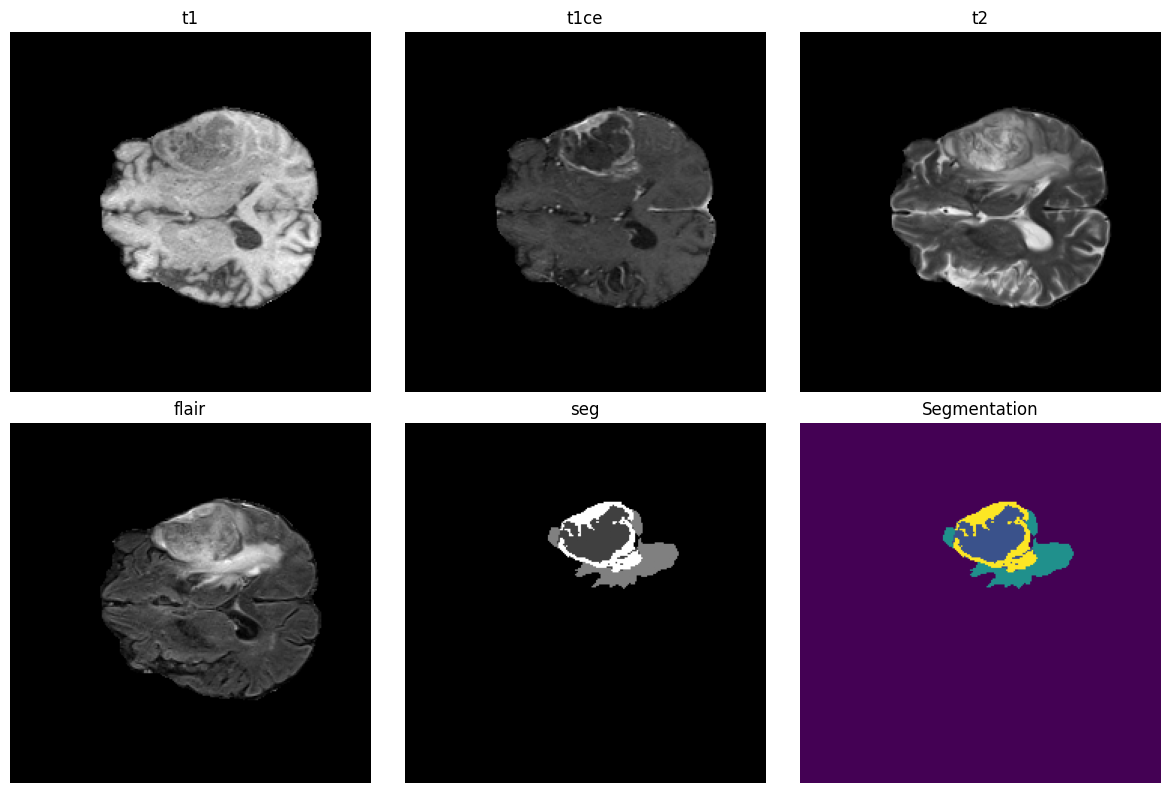

Shape of t1: (240, 240, 155)
slice index = 77


In [ ]:
# load and normalize a modality
def load_nifti_image(file_path):
    image = nib.load(file_path).get_fdata() # Extracting the image data as a NumPy array
    scaler = MinMaxScaler() # rescaling data between 0 and 1
    image = scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)
    return image

# Load MRI images
def load_patient_images(patient_id, dataset_path):
  # Full path to patient data
  patient_path = os.path.join(dataset_path, patient_id)
  images = {
      "t1": load_nifti_image(os.path.join(patient_path, f"{patient_id}_t1.nii")),
      "t1ce": load_nifti_image(os.path.join(patient_path, f"{patient_id}_t1ce.nii")),
      "t2": load_nifti_image(os.path.join(patient_path, f"{patient_id}_t2.nii")),
      "flair": load_nifti_image(os.path.join(patient_path, f"{patient_id}_flair.nii")),
      # Load segmentation mask (Without normalization)
      "seg": nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii")).get_fdata()
  }
  return images

def visualize_middle_slice(images):
    slice_idx = next(iter(images.values())).shape[2] // 2

    modalities = list(images.keys())
    num_modalities = len(modalities)

    plt.figure(figsize=(12, 8))

    for i, modality in enumerate(modalities):
        plt.subplot(2, 3, i + 1)
        cmap = 'gray'
        plt.imshow(images[modality][:, :, slice_idx], cmap=cmap)
        plt.title(modality)
        plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(images['seg'][:, :, slice_idx], cmap='viridis')
    plt.title('Segmentation')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Shape of {modalities[0]}: {images[modalities[0]].shape}")
    print(f"slice index = {slice_idx}")

# Choose the patient folder as an example
patient_id = "BraTS20_Training_100"

# Load patient data
patient_data = load_patient_images(patient_id, dataset_path)

# Visualization patient data
visualize_middle_slice(patient_data)

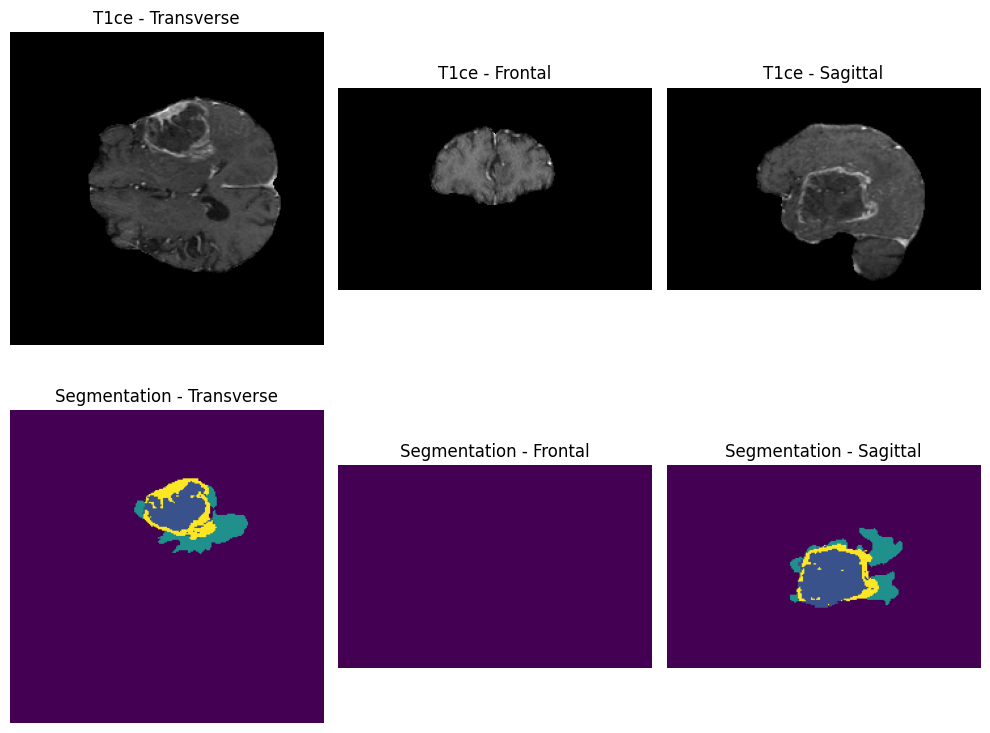

In [ ]:
slice_idx = 77
plt.figure(figsize=(10, 8))

# Define views with different modalities and orientations
views = {
    "T1ce - Transverse": patient_data['t1ce'][:, :, slice_idx],
    "T1ce - Frontal": rotate(patient_data['t1ce'][:, slice_idx, :], 90, resize=True),
    "T1ce - Sagittal": rotate(patient_data['t1ce'][slice_idx, :, :], 90, resize=True),

    "Segmentation - Transverse": patient_data['seg'][:, :, slice_idx],
    "Segmentation - Frontal": rotate(patient_data['seg'][:, slice_idx, :], 90, resize=True),
    "Segmentation - Sagittal": rotate(patient_data['seg'][slice_idx, :, :], 90, resize=True),
}

# Plotting each view
num_views = len(views)
cols = 3
rows = num_views // cols + (num_views % cols > 0)

for i, (title, img) in enumerate(views.items(), 1):
    plt.subplot(rows, cols, i)
    cmap = "gray" if "Segmentation" not in title else "viridis"
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

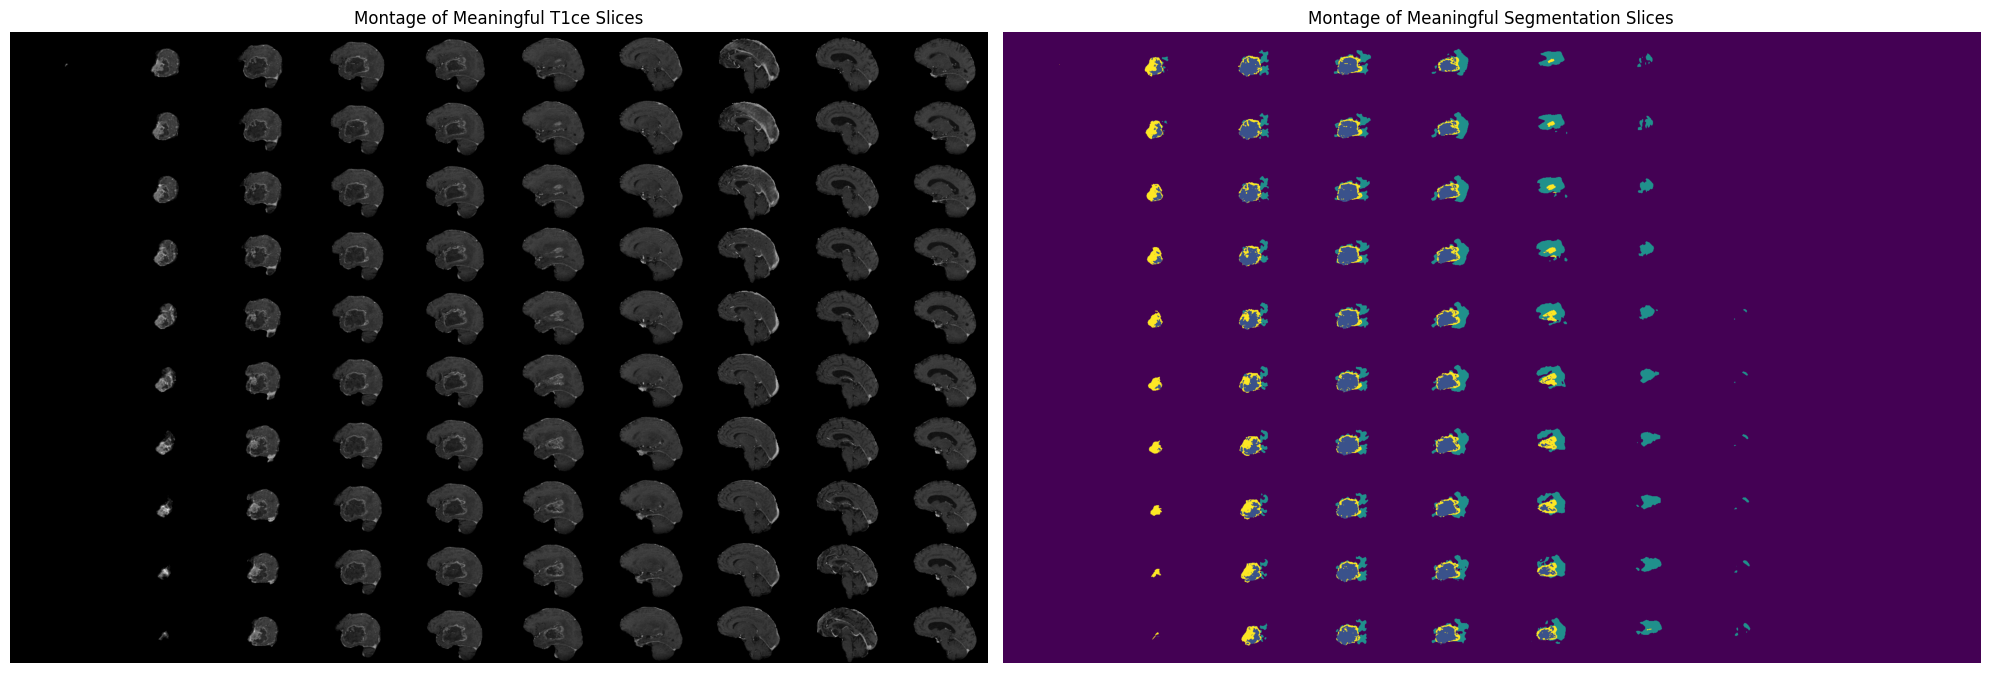

In [ ]:
def show_side_by_side_montages(patient_data):
    # Extract and process meaningful slices
    t1ce_slices = patient_data['t1ce'][40:140]
    seg_slices = patient_data['seg'][40:140, :, :]

    # Generate montages
    montage_t1ce = rotate(montage(t1ce_slices), 90, resize=True)
    montage_seg = rotate(montage(seg_slices), 90, resize=True)

    # Plot side by side
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(montage_t1ce, cmap="gray")
    plt.title("Montage of Meaningful T1ce Slices")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(montage_seg, cmap="viridis")
    plt.title("Montage of Meaningful Segmentation Slices")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_side_by_side_montages(patient_data)

Unique values in segmentation slice: [0. 1. 2. 4.]


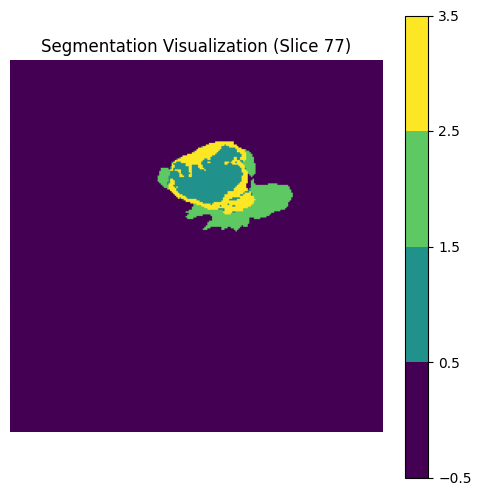

In [ ]:
print("Unique values in segmentation slice:", np.unique(patient_data['seg'][:, :, slice_idx]))

# Define a colormap with four colors for four segmentation classes
cmap = mcolors.ListedColormap(['#440154', '#21918c', '#5ec962', '#fde725'])

norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# The segmentation
plt.figure(figsize=(6, 6))
plt.imshow(patient_data['seg'][:, :, slice_idx], cmap=cmap, norm=norm)
plt.colorbar()
plt.title(f"Segmentation Visualization (Slice {slice_idx})")
plt.axis("off")
plt.show()

## 3D Brain Tumor Visualization with Plotly

Interactive 3D demo live 👉 https://t.co/8WimhfZKKn

Setting up this 3D visualization on Hugging Face Spaces requires the following files:

`requirements.txt`

`app.py`

In [ ]:
# app.py

# Extract tumor regions from segmentation mask
# This creates a binary mask: True where there is tumor (seg > 0), False elsewhere
tumor_mask = (patient_data['seg'] > 0)

# Generate a 3D mesh from the tumor mask using the marching cubes algorithm
# This converts the tumor volume into vertices and faces for 3D surface rendering
# Face is a triangle that connects 3 points (vertices) to form part of a 3D mesh surface
verts_tumor, faces_tumor, _, values_tumor = measure.marching_cubes(tumor_mask, level=0)

# Extract brain structure
# This creates a binary mask: True where T1 image is background (t1 == 0)
brain_mask = (patient_data['t1'] == 0)

# Generate a mesh from the brain mask
# Creates vertices and faces to form a 3D surface of the brain outline
verts_brain, faces_brain, _, _ = measure.marching_cubes(brain_mask, level=0)

# Create an empty 3D Plotly figure
fig = go.Figure()

# Add brain structure mesh
# Use Mesh3d to visualize the brain's outer boundary in 3D
fig.add_trace(go.Mesh3d(
    x=verts_brain[:, 0],  # X-coordinates of all vertices
    y=verts_brain[:, 1],  # Y-coordinates
    z=verts_brain[:, 2],  # Z-coordinates
    i=faces_brain[:, 0],  # First vertex index of each triangle
    j=faces_brain[:, 1],  # Second vertex index
    k=faces_brain[:, 2],  # Third vertex index
    color='pink',         # Solid color for the brain surface
    opacity=0.1,          # Very transparent to keep focus on tumor
    name='Brain'          # Legend label
))

# Add tumor mesh with depth-based coloring (Viridis colormap)
# This makes the tumor visible with colors based on Z-depth
fig.add_trace(go.Mesh3d(
    x=verts_tumor[:, 0],           # X-coordinates of tumor surface
    y=verts_tumor[:, 1],           # Y-coordinates
    z=verts_tumor[:, 2],           # Z-coordinates
    i=faces_tumor[:, 0],           # First index of each triangle
    j=faces_tumor[:, 1],           # Second index
    k=faces_tumor[:, 2],           # Third index
    intensity=verts_tumor[:, 2],   # Color the surface based on Z-depth
    colorscale='Viridis',          # Apply Viridis colormap
    opacity=0.9,                   # High opacity to emphasize tumor structure
    name='Tumor'                   # Legend label
))

# Set figure layout and scene details
fig.update_layout(
    title='3D Tumor Visualization with Brain Context', # Title of the plot
    scene=dict(  # Axis and aspect ratio settings
        xaxis_title='Width',   # Label X-axis
        yaxis_title='Height',  # Label Y-axis
        zaxis_title='Depth',   # Label Z-axis
        aspectratio=dict(x=1, y=1, z=0.7) # Shape ratio of the 3D space
    ),
    width=800, # Width of the plot window
    height=800 # Height of the plot window
)

# Render the plot
fig.show()

## Split Dataset

In [ ]:
# List all folders that start with 'BraTS20_Training_'
all_cases = sorted([d for d in os.listdir(dataset_path) if d.startswith("BraTS20_Training_")])

# Remove the problematic case
if 'BraTS20_Training_355' in all_cases:
    all_cases.remove('BraTS20_Training_355')
    cases = all_cases

print(f"Total Cases: {len(all_cases)}")
print(f"Total cases selected: {len(cases)}")
print("Example case IDs:", cases[:5])  # To check everything works well

Total Cases: 368
Total cases selected: 368
Example case IDs: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']


In [ ]:
if 'BraTS20_Training_355' in cases :
  print(False)
else :
  print(True)

True


In [ ]:
# Unique labels across all cases
all_labels = set()

# Loop through all cases
for case in cases:
    seg_path = os.path.join(dataset_path, case, f"{case}_seg.nii")

    if os.path.exists(seg_path):  # Ensure the segmentation file exists
        seg = nib.load(seg_path).get_fdata()
        unique_labels = np.unique(seg)  # Get unique labels for this case
        all_labels.update(unique_labels)  # Add to the set

# Print the final unique labels found in the dataset
print("Unique labels in the entire dataset:", sorted(all_labels))

Unique labels in the entire dataset: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(4.0)]


Number of training cases: 235
Number of validation cases: 74
Number of test cases: 59


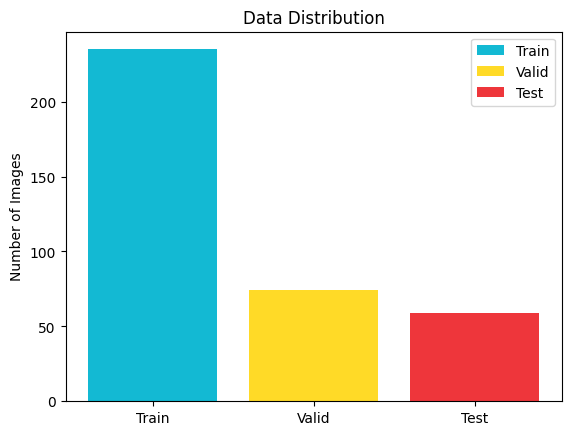

In [ ]:
# Split into Train, Validation, and Test
# 80% of the 300 patients for training and testing, 20% for validation
train_and_test_ids, val_ids = train_test_split(
    cases,
    test_size=0.2,
    random_state=42
)

# From that 70%, split 80% for training, 20% for testing
train_ids, test_ids = train_test_split(
    train_and_test_ids,
    test_size=0.2,
    random_state=42
)

print(f"Number of training cases: {len(train_ids)}")
print(f"Number of validation cases: {len(val_ids)}")
print(f"Number of test cases: {len(test_ids)}")

# Visualization of dataset Distribution
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ '#13b9d3','#ffda27', '#ee363b'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

## Data Generator




In [ ]:
# Define segmentation-areas
segmentation_class = {
    0 : 'Background', # No Tumor
    1 : 'Necrotic Tumor Core',
    2 : 'Peritumoral Edema',
    3 : 'Enhancing Tumor' # original 4 that converted into 3
}

# Selecting constants
volume_slices = 100
start_volume = 25 # first slice of volume that we will include
img_size = 128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    """Generates data to handling large MRI datasets efficiently."""

    def __init__(self, list_IDs, dim=(img_size, img_size), batch_size=1, n_channels=2, shuffle=True):
        """
        Initializes the data generator with parameters.

        Parameters:
        - list_IDs: List of patient IDs (folder names).
        - dim: Target image size (default: 128x128).
        - batch_size: Number of patients to process per batch (default: 1).
        - n_channels: Number of input image channels (default: 2 - T1ce + FLAIR).
        - shuffle: Whether to shuffle patient data at the end of each epoch (default: True).
        """
        super().__init__()
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Returns how many batches there are per epoch.
        The total dataset size is divided by batch_size to determine the steps per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates one batch of data.

        Parameters:
        - index: Index of the batch.

        Returns:
        - X: Input MRI images of shape (batch_size * VOLUME_SLICES, 128, 128, 2).
        - Y: One-hot encoded segmentation masks of shape (batch_size * VOLUME_SLICES, 128, 128, 4).
        """
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(batch_ids)

    def on_epoch_end(self):
        """Updates indexes after each epoch to shuffle the dataset."""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        """
        Generates batch data for model training.

        Parameters:
        - Batch_ids: List of patient IDs to be processed in this batch.

        Returns:
        - X: Preprocessed MRI scans (batch_size * VOLUME_SLICES, 128, 128, 2).
        - Y: Corresponding one-hot encoded segmentation masks (batch_size * VOLUME_SLICES, 128, 128, 4).
        """
        X = np.zeros((self.batch_size * volume_slices, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * volume_slices, 240, 240))

        for c, i in enumerate(batch_ids):
            case_path = os.path.join(dataset_path, i)

            # Load MRI scans
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            # Process each volume slice
            for j in range(volume_slices):
                X[j + volume_slices * c, :, :, 0] = cv2.resize(flair[:, :, j + start_volume], self.dim)
                X[j + volume_slices * c, :, :, 1] = cv2.resize(t1ce[:, :, j + start_volume], self.dim)
                y[j + volume_slices * c] = seg[:, :, j + start_volume]

        # Adjust labels: Relabel class 4 to 3 (since class 3 does not exist)
        y[y == 4] = 3

        # Convert mask to one-hot encoding and resize
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, self.dim)

        # Normalize input images
        return X / np.max(X), Y

# Instantiate the data generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

Input shape: (100, 128, 128, 2)
Label shape: (100, 128, 128, 4)
Input dtype: float64
Label dtype: <dtype: 'float32'>


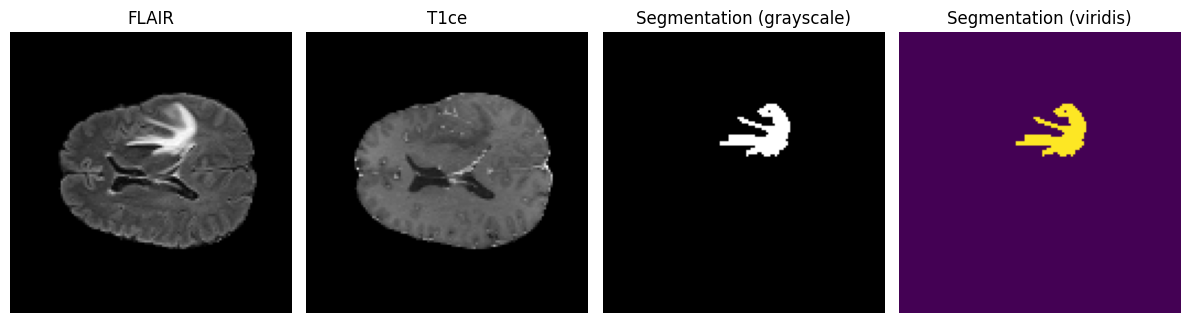

Indexes before shuffling: [110  98  70 192 188   2 105 149 197  69]
Indexes after shuffling:  [125 226  55  27  57   7 122 139 201 108]


In [ ]:
# Get one batch of data from the training generator
X_batch, Y_batch = training_generator.__getitem__(0)

# Print shapes and types for verification
print("Input shape:", X_batch.shape)  # Expected: (batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_channels)
print("Label shape:", Y_batch.shape)  # Expected: (batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, num_classes)
print("Input dtype:", X_batch.dtype)
print("Label dtype:", Y_batch.dtype)

# Function to display a single slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('FLAIR')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='gray')
    axes[2].set_title('Segmentation (grayscale)')
    axes[2].axis('off')

    axes[3].imshow(segmentation, cmap='viridis')
    axes[3].set_title('Segmentation (viridis)')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Load a specific batch (e.g., batch 8)
X_batch, Y_batch = training_generator[10]

# Split the modalities and decode the mask
flair_batch = X_batch[:, :, :, 0]          # Channel 0: FLAIR
t1ce_batch = X_batch[:, :, :, 1]           # Channel 1: T1ce
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot to class labels

# Choose a slice to visualize
slice_index = 60
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the selected slice
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# Check index shuffling behavior
indexes_before = training_generator.indexes.copy()
training_generator.on_epoch_end()
indexes_after = training_generator.indexes

print("Indexes before shuffling:", indexes_before[:10])
print("Indexes after shuffling: ", indexes_after[:10])

## Evaluation Measures




In [ ]:
# Computes the average Dice coefficient across all classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = y_true.shape[-1] # Number of classes
    dice_scores = [] # Stores Dice scores for each class

    # Loop through each class and calculate the Dice coefficient
    for i in range(class_num):
        y_true_f = K.batch_flatten(y_true[..., i]) # Flatten the ground truth mask
        y_pred_f = K.batch_flatten(y_pred[..., i]) # Flatten the predicted mask
        intersection = K.sum(y_true_f * y_pred_f)  # Computes the intersection

        # Compute Dice score for the current class
        score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        dice_scores.append(score)

    # Returns the mean Dice score across all classes
    return K.mean(K.stack(dice_scores))

# Calculates the Dice coefficient for a specific class
def dice_coef_per_class(y_true, y_pred, class_idx, epsilon=1e-6):
    y_true_f = K.batch_flatten(y_true[..., class_idx]) # Flatten the ground truth mask
    y_pred_f = K.batch_flatten(y_pred[..., class_idx]) # Flatten the predicted mask
    intersection = K.sum(y_true_f * y_pred_f) # Computes the intersection

    # Computes the Dice score for the specified class
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

# Class-specific metrics
def dice_coef_necrotic(y_true, y_pred): return dice_coef_per_class(y_true, y_pred, 1)
def dice_coef_edema(y_true, y_pred): return dice_coef_per_class(y_true, y_pred, 2)
def dice_coef_enhancing(y_true, y_pred): return dice_coef_per_class(y_true, y_pred, 3)

In [ ]:
def precision(y_true, y_pred):
    y_pred = K.round(K.clip(y_pred, 0, 1))
    y_true = K.round(K.clip(y_true, 0, 1))

    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)

    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    y_pred = K.round(K.clip(y_pred, 0, 1))
    y_true = K.round(K.clip(y_true, 0, 1))

    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)

    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_pred = K.round(K.clip(y_pred, 0, 1))
    y_true = K.round(K.clip(y_true, 0, 1))

    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)

    return true_negatives / (possible_negatives + K.epsilon())

## Define The Model

In [ ]:
def build_unet(inputs, ker_init='he_normal', dropout=0.2):
    """
    inputs: The input tensor
    ker_init: The initializer for kernel weights
    dropout: Dropout rate to help prevent overfitting in the bottleneck.
    """

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Output
    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

# Define model input
input_layer = Input(shape=(img_size, img_size, 2))

# Build U-Net model
model = build_unet(input_layer, 'he_normal', 0.2)

In [ ]:
# Dice loss and combined loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, 4])
    y_pred_f = tf.reshape(y_pred, [-1, 4])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return ce + dl

In [ ]:
model.compile(
    loss=combined_loss,
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        MeanIoU(num_classes=4, name="mean_io_u"),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    CSVLogger('training.log', separator=',', append=False)
]

In [ ]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    524,544 │ up_sampling2d[0]

 Total params: 7,759,908 (29.60 MB)

 Trainable params: 7,759,908 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning:

The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.



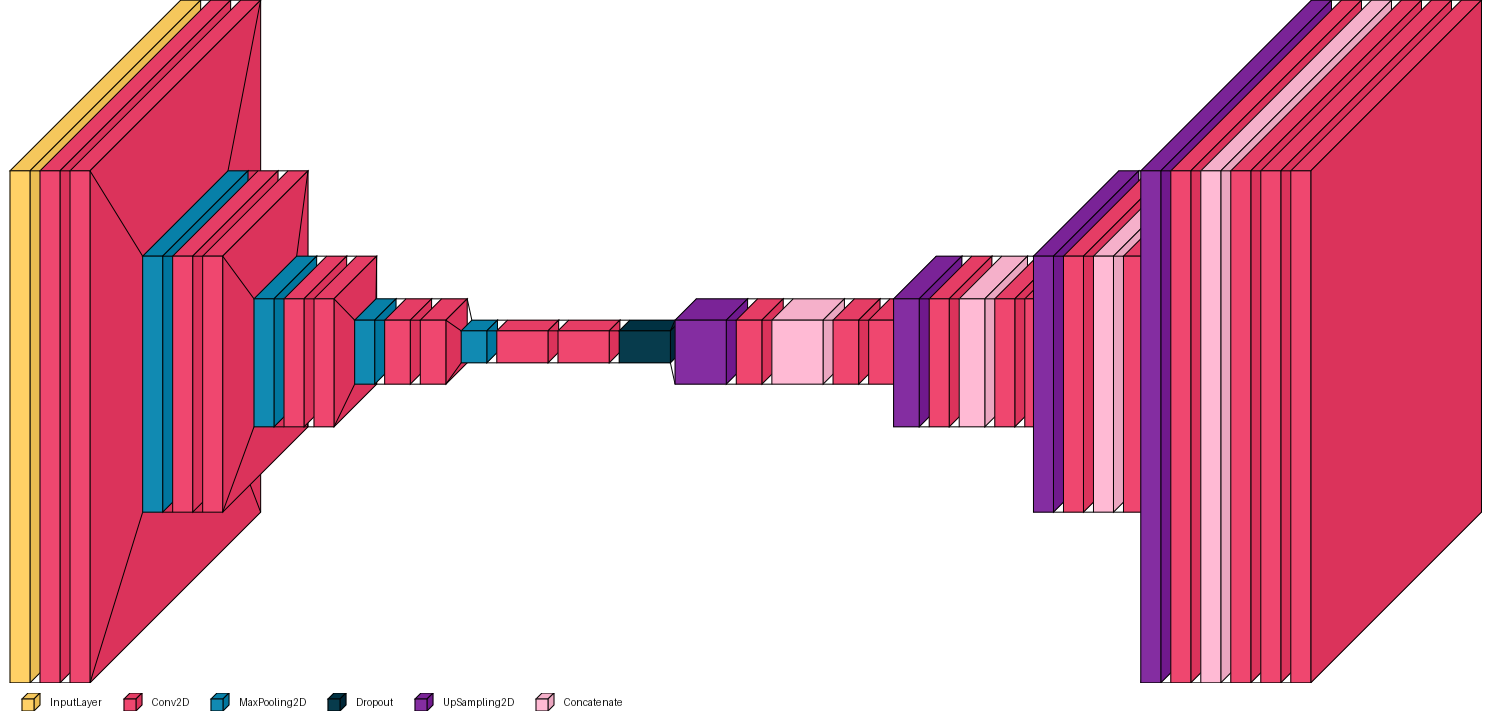

In [ ]:
# Visualization
visualkeras.layered_view(model, legend=True)

In [ ]:
# Train the U-Net model
history =  model.fit(training_generator, # Training data generator
                    epochs=35, # Number of training epochs
                    steps_per_epoch=len(train_ids), # Number of steps per epoch
                    callbacks= callbacks, # Callbacks
                    validation_data = valid_generator # Validation data generator
                    )

Epoch 1/35
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - dice_coef: 0.2550 - dice_coef_edema: 0.0483 - dice_coef_enhancing: 0.0135 - dice_coef_necrotic: 0.0182 - loss: 0.9685 - mean_io_u: 0.5516 - precision: 0.9556 - sensitivity: 0.9090 - specificity: 0.9948
Epoch 1: val_loss improved from inf to 0.85315, saving model to model_.01-0.853152.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 246s 926ms/step - dice_coef: 0.2551 - dice_coef_edema: 0.0484 - dice_coef_enhancing: 0.0135 - dice_coef_necrotic: 0.0182 - loss: 0.9680 - mean_io_u: 0.5518 - precision: 0.9557 - sensitivity: 0.9092 - specificity: 0.9948 - val_dice_coef: 0.2660 - val_dice_coef_edema: 0.0485 - val_dice_coef_enhancing: 0.0081 - val_dice_coef_necrotic: 0.0164 - val_loss: 0.8532 - val_mean_io_u: 0.8200 - val_precision: 0.9836 - val_sensitivity: 0.9825 - val_specificity: 0.9945 - learning_rate: 0.0010
Epoch 2/35
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - dice_coef: 0.2858 - dice_coef_edema: 0.1083 - dice_coef_enhancing: 0.0204 - dic

In [ ]:
# Save the model
model.save("my_model.keras")

## Load The Trained Model

In [ ]:
# After training is complete (history = model.fit(...))
history_dict = history.history

# Optional: just to see what was tracked
print(history_dict.keys())

# Extract only custom metrics (skip loss or accuracy if desired)
custom_metric_keys = [
    "dice_coef", "precision", "sensitivity", "specificity",
    "dice_coef_necrotic", "dice_coef_edema", "dice_coef_enhancing",
    "mean_io_u",  # Keras renames MeanIoU to lowercase snake_case by default
]

# Print header
print("\n Final Custom Training Metrics")
print("=" * 40)

# Loop and print metrics if they exist in history
for key in custom_metric_keys:
    if key in history_dict:
        value = history_dict[key][-1]
        print(f"{key:<25}: {value:.4f}")
    else:
        print(f"{key:<25}: [not tracked]")

dict_keys(['dice_coef', 'dice_coef_edema', 'dice_coef_enhancing', 'dice_coef_necrotic', 'loss', 'mean_io_u', 'precision', 'sensitivity', 'specificity', 'val_dice_coef', 'val_dice_coef_edema', 'val_dice_coef_enhancing', 'val_dice_coef_necrotic', 'val_loss', 'val_mean_io_u', 'val_precision', 'val_sensitivity', 'val_specificity', 'learning_rate'])

 Final Custom Training Metrics
dice_coef                : 0.7609
precision                : 0.9943
sensitivity              : 0.9942
specificity              : 0.9981
dice_coef_necrotic       : 0.6285
dice_coef_edema          : 0.7100
dice_coef_enhancing      : 0.7049
mean_io_u                : 0.8153


In [ ]:
# Define custom metrics as functions and classes (not instantiated objects)

custom_metrics = {
    "dice_coef": dice_coef,
    "precision": precision,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "dice_coef_necrotic": dice_coef_necrotic,
    "dice_coef_edema": dice_coef_edema,
    "dice_coef_enhancing": dice_coef_enhancing,
    "mean_io_u": MeanIoU(num_classes=4, name="mean_io_u")
}



# Load the model with custom objects
model = load_model("/content/my_model.keras", custom_objects=custom_metrics, compile=False)

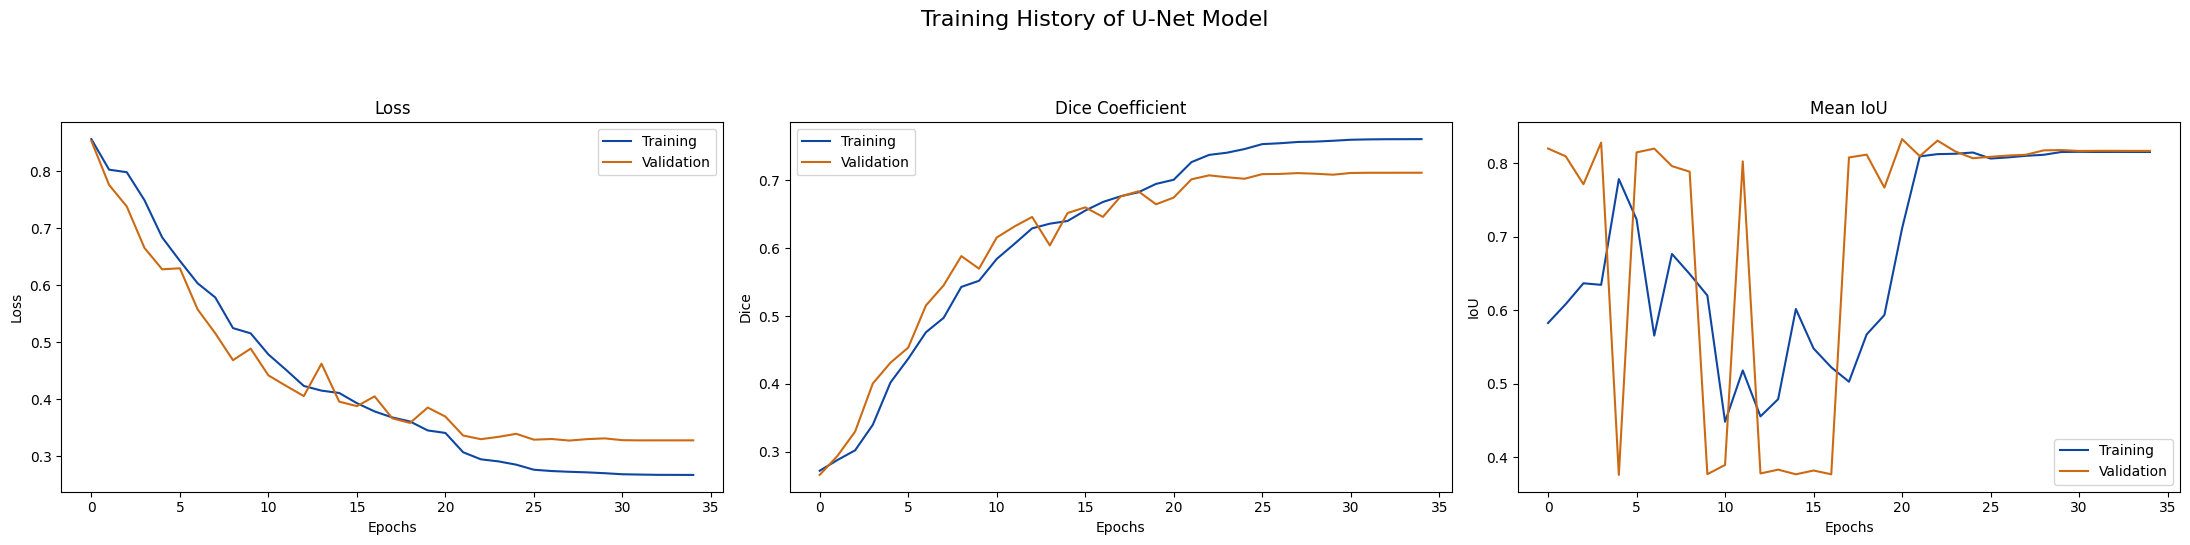

In [ ]:
# visualizing the training progress of U-Net model over time
## Load training history from CSV
history = pd.read_csv('/content/training.log', sep=',', engine='python')
epochs = range(len(history))

# Define plot colors
train_color = '#0e46a1'
val_color = '#cc6a14'

# Define reusable plot function
def plot_metric(ax, history, train_key, val_key, title, ylabel):
    if train_key in history and val_key in history:
        ax.plot(epochs, history[train_key], color=train_color, label='Training')
        ax.plot(epochs, history[val_key], color=val_color, label='Validation')
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(ylabel)
        ax.legend()
    else:
        ax.set_title(f"{title} (Not Found)")
        ax.axis('off')

# Create 1x4 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

# Plot metrics using safe function
plot_metric(axes[0], history, 'loss', 'val_loss', 'Loss', 'Loss')
plot_metric(axes[1], history, 'dice_coef', 'val_dice_coef', 'Dice Coefficient', 'Dice')
plot_metric(axes[2], history, 'mean_io_u', 'val_mean_io_u', 'Mean IoU', 'IoU')

# Optional: Add a main title
fig.suptitle('Training History of U-Net Model', fontsize=16, y=1.08)

# Tidy layout
plt.tight_layout()
plt.show()

In [ ]:
custom_metric_keys = [
    "dice_coef", "precision", "sensitivity", "specificity",
    "dice_coef_necrotic", "dice_coef_edema", "dice_coef_enhancing",
    "mean_io_u"
]

print("\n Final Custom Training Metrics (from CSV)")
print("=" * 50)

for key in custom_metric_keys:
    if key in history.columns:
        print(f"{key:<25}: {history[key].iloc[-1]:.4f}")
    else:
        print(f"{key:<25}: [not tracked]")


 Final Custom Training Metrics (from CSV)
dice_coef                : 0.7609
precision                : 0.9943
sensitivity              : 0.9942
specificity              : 0.9981
dice_coef_necrotic       : 0.6285
dice_coef_edema          : 0.7100
dice_coef_enhancing      : 0.7049
mean_io_u                : 0.8153


## Visualization Some Samples

In [ ]:
def get_safe_volume_slices(volume):
    """Ensure we don't exceed the available slices in the 3D scan."""
    return min(volume_slices, volume.shape[2] - start_volume)

def image_loader(path):
    """Load a 3D MRI scan from a NIfTI file."""
    return np.array(nib.load(path).get_fdata())

def predict_by_path(case_path, case_id):
    """Predict tumor segmentation for a case using flair + t1ce scans."""
    flair = image_loader(os.path.join(case_path, f'BraTS20_Training_{case_id}_flair.nii'))
    t1ce = image_loader(os.path.join(case_path, f'BraTS20_Training_{case_id}_t1ce.nii'))

    safe_slices = get_safe_volume_slices(flair)
    X = np.empty((safe_slices, img_size, img_size, 2))

    for j in range(safe_slices):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + start_volume], (img_size, img_size))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j + start_volume], (img_size, img_size))

    return model.predict(X / np.max(X), verbose=1)

In [ ]:
def show_predicts_by_id(case_id, start_slice=60):
    """Display original flair, ground truth, and model predictions for a given case and slice."""
    path = os.path.join(dataset_path, f'BraTS20_Training_{case_id}')

    # Load images
    flair = image_loader(os.path.join(path, f'BraTS20_Training_{case_id}_flair.nii'))
    ground_truth = image_loader(os.path.join(path, f'BraTS20_Training_{case_id}_seg.nii'))
    prediction = predict_by_path(path, case_id)

    # Extract individual segmentation classes
    core = prediction[:, :, :, 1]
    edema = prediction[:, :, :, 2]
    enhancing = prediction[:, :, :, 3]

    slice_idx = start_slice + start_volume
    base_flair = cv2.resize(flair[:, :, slice_idx], (img_size, img_size))

    fig, axes = plt.subplots(1, 6, figsize=(24, 6))

    for ax in axes:
        ax.imshow(base_flair, cmap='gray')

    axes[0].set_title('Original Flair')
    axes[1].imshow(cv2.resize(ground_truth[:, :, slice_idx], (img_size, img_size), interpolation=cv2.INTER_NEAREST), cmap='Reds', alpha=0.4)
    axes[1].set_title('Ground Truth')
    axes[2].imshow(prediction[start_slice, :, :, 1:4].sum(axis=-1), cmap='Reds', alpha=0.4)
    axes[2].set_title('All Classes')
    axes[3].imshow(edema[start_slice], cmap='OrRd', alpha=0.4)
    axes[3].set_title(f'{segmentation_class[2]}')
    axes[4].imshow(core[start_slice], cmap='OrRd', alpha=0.4)
    axes[4].set_title(f'{segmentation_class[1]}')
    axes[5].imshow(enhancing[start_slice], cmap='OrRd', alpha=0.4)
    axes[5].set_title(f'{segmentation_class[3]}')

    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


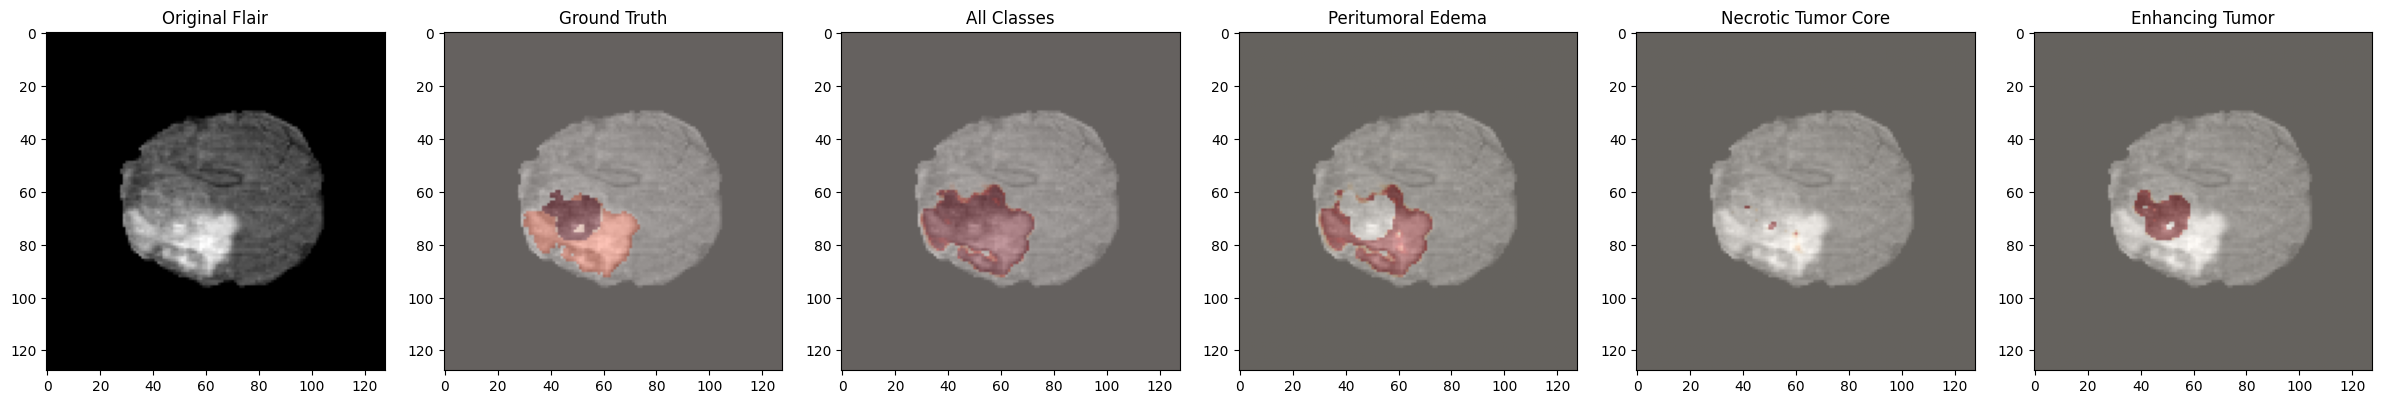

In [ ]:
show_predicts_by_id(case_id='210', start_slice=77)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


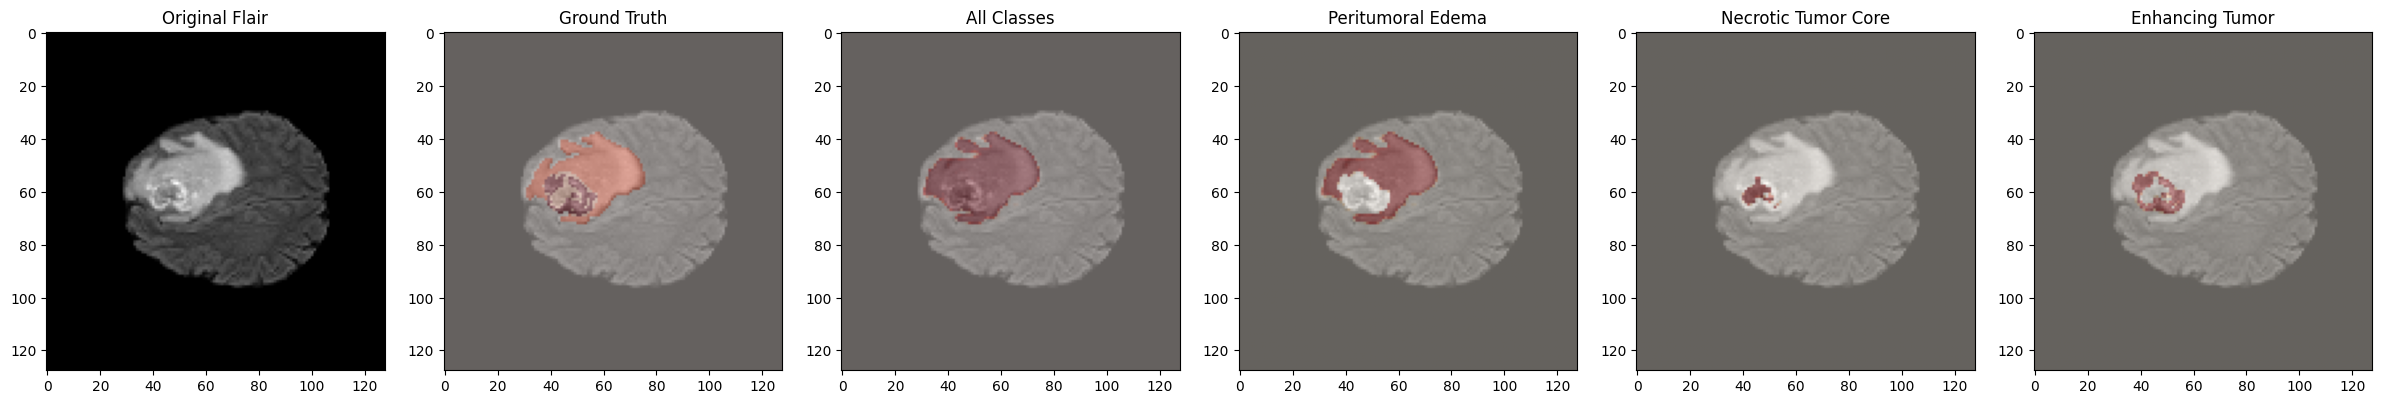

In [ ]:
show_predicts_by_id(case_id='098', start_slice=77)

In [ ]:
def predict_segmentation(patient_path):
    """Predicts the tumor segmentation for a given patient's MRI scans."""
    t1ce_path = patient_path + '_t1ce.nii'
    flair_path = patient_path + '_flair.nii'

    # Load MRI scans
    t1ce_scan = image_loader(t1ce_path)
    flair_scan = image_loader(flair_path)

    # Get safe slice count
    safe_slices = get_safe_volume_slices(flair_scan)

    # Create an empty array for model input
    X = np.empty((safe_slices, img_size, img_size, 2))

    # Resize slices to match the model's expected input shape
    for j in range(safe_slices):
        X[j, :, :, 0] = cv2.resize(flair_scan[:, :, j + start_volume], (img_size, img_size))
        X[j, :, :, 1] = cv2.resize(t1ce_scan[:, :, j + start_volume], (img_size, img_size))

    # Normalize input and make predictions
    return model.predict(X / np.max(X), verbose=1)

def show_predicted_segmentations(samples_list, slice_index, cmap, norm):
    """Displays the original ground truth segmentation and predicted segmentations."""
    # Select a random patient sample
    selected_sample = random.choice(samples_list)

    # Construct full path to patient's MRI scans
    patient_path = os.path.join(dataset_path, selected_sample, selected_sample)

    # Predict segmentation for the selected patient
    predicted_segmentation = predict_segmentation(patient_path)

    # Load ground truth segmentation
    ground_truth_path = patient_path + '_seg.nii'
    ground_truth = image_loader(ground_truth_path)

    # Get the total number of slices
    total_slices = ground_truth.shape[2]

    # Ensure `slice_index` does not exceed available slices
    if slice_index + start_volume >= total_slices:
        slice_index = total_slices - start_volume - 1  # Set to the last valid slice

    # Resize ground truth segmentation
    ground_truth_resized = cv2.resize(ground_truth[:, :, slice_index + start_volume],
                                      (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Extract different segmentation components
    predicted_all = predicted_segmentation[slice_index, :, :, 1:4]  # All tumor classes
    predicted_background = predicted_segmentation[slice_index, :, :, 0]  # Background
    predicted_core = predicted_segmentation[slice_index, :, :, 1]  # Core tumor
    predicted_edema = predicted_segmentation[slice_index, :, :, 2]  # Edema
    predicted_enhancing = predicted_segmentation[slice_index, :, :, 3]  # Enhancing tumor

    # Display original and predicted segmentations
    print("Patient ID:", selected_sample)
    fig, axes = plt.subplots(1, 6, figsize=(25, 20))

    # Ground truth segmentation
    axes[0].imshow(ground_truth_resized, cmap=cmap, norm=norm)
    axes[0].set_title('Ground Truth Segmentation')

    # All predicted tumor classes
    axes[1].imshow(predicted_all, cmap=cmap, norm=norm)
    axes[1].set_title('All Classes')

    # Background prediction
    axes[2].imshow(predicted_background)
    axes[2].set_title('Not Tumor')

    # Core tumor prediction
    axes[3].imshow(predicted_core)
    axes[3].set_title('Core')

    # Edema prediction
    axes[4].imshow(predicted_edema)
    axes[4].set_title('Edema')

    # Enhancing tumor prediction
    axes[5].imshow(predicted_enhancing)
    axes[5].set_title('Enhancing')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.8)
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Patient ID: BraTS20_Training_114


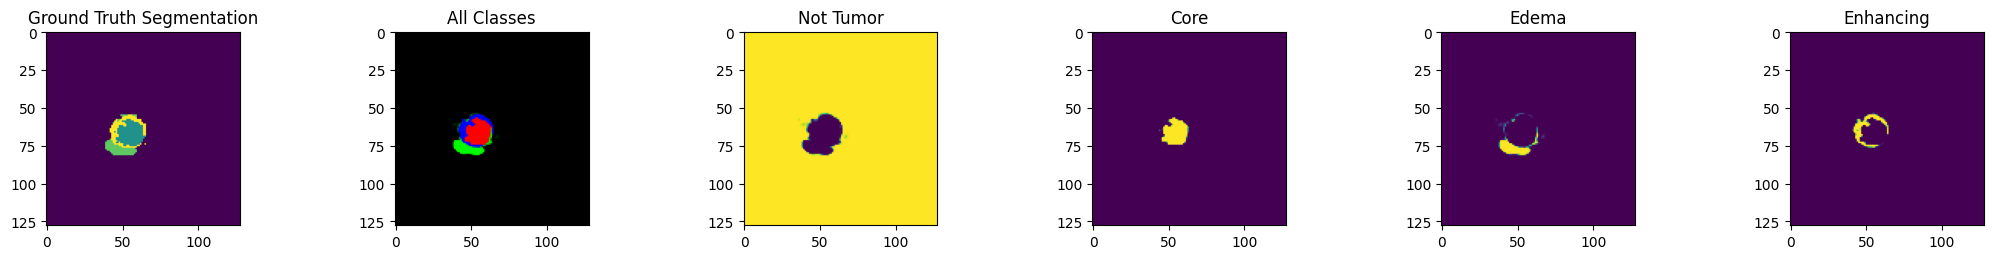

In [ ]:
# Sample
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Patient ID: BraTS20_Training_264


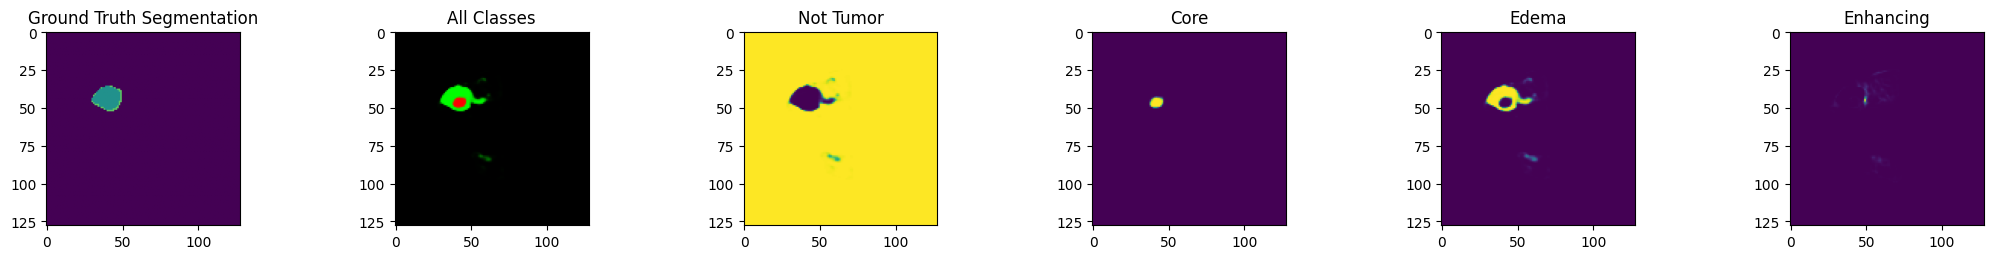

In [ ]:
# Sample
show_predicted_segmentations(test_ids, 60, cmap, norm)

## Testing

In [ ]:
# Cheching
import os
print([f for f in os.listdir() if f.endswith(".weights.h5")])

['model_.07-0.557503.weights.h5', 'model_.01-0.853152.weights.h5', 'model_.23-0.329619.weights.h5', 'model_.28-0.327196.weights.h5', 'model_.12-0.423160.weights.h5', 'model_.26-0.328741.weights.h5', 'model_.03-0.737972.weights.h5', 'model_.04-0.665222.weights.h5', 'model_.15-0.395521.weights.h5', 'model_.19-0.358123.weights.h5', 'model_.05-0.627692.weights.h5', 'model_.16-0.387587.weights.h5', 'model_.22-0.336055.weights.h5', 'model_.11-0.441615.weights.h5', 'model_.09-0.468233.weights.h5', 'model_.18-0.366215.weights.h5', 'model_.02-0.775888.weights.h5', 'model_.13-0.405229.weights.h5', 'model_.08-0.515393.weights.h5']


## Evaluation

In [ ]:
# Checking
print(type(test_generator))

<class '__main__.DataGenerator'>


In [ ]:
# Compile the model with the same loss and metrics used during training
model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=4, name="mean_io_u"),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate on training set
results = model.evaluate(training_generator, verbose=1)

eval_param = [
              "Loss",
              "MeanIOU",
              "Dice coefficient",
              "Precision",
              "Sensitivity",
              "Specificity",
              "Dice coef Necrotic",
              "Dice coef Edema",
              "Dice coef Enhancing"
              ]

# Combine results list and eval_param list
results_list = zip(results, eval_param)

# Display each metric with its eval_param
print("\n Model evaluation on the test set:")
for i, (metric, eval_param) in enumerate(results_list):
    print(f"{eval_param} : {round(metric, 4)}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - dice_coef: 0.7542 - dice_coef_edema: 0.6991 - dice_coef_enhancing: 0.6955 - dice_coef_necrotic: 0.6220 - loss: 0.2749 - mean_io_u: 0.8137 - precision: 0.9940 - sensitivity: 0.9939 - specificity: 0.9980

 Model evaluation on the test set:
Loss : 0.2668
MeanIOU : 0.8153
Dice coefficient : 0.7609
Precision : 0.9943
Sensitivity : 0.9942
Specificity : 0.9981
Dice coef Necrotic : 0.6286
Dice coef Edema : 0.7101
Dice coef Enhancing : 0.7049


In [ ]:
# Compile the model with the same loss and metrics used during training
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=4, name="mean_io_u"),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate on training set
results = model.evaluate(training_generator, verbose=1)

eval_param = [
              "Loss",
              "MeanIOU",
              "Dice coefficient",
              "Precision",
              "Sensitivity",
              "Specificity",
              "Dice coef Necrotic",
              "Dice coef Edema",
              "Dice coef Enhancing"
              ]

# Combine results list and eval_param list
results_list = zip(results, eval_param)

# Display each metric with its eval_param
print("\n Model evaluation on the test set:")
for i, (metric, eval_param) in enumerate(results_list):
    print(f"{eval_param} : {round(metric, 4)}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 53s 213ms/step - dice_coef: 0.7574 - dice_coef_edema: 0.7086 - dice_coef_enhancing: 0.6895 - dice_coef_necrotic: 0.6312 - loss: 0.0276 - mean_io_u: 0.8156 - precision: 0.9943 - sensitivity: 0.9942 - specificity: 0.9981

 Model evaluation on the test set:
Loss : 0.0272
MeanIOU : 0.8153
Dice coefficient : 0.7609
Precision : 0.9943
Sensitivity : 0.9942
Specificity : 0.9981
Dice coef Necrotic : 0.6286
Dice coef Edema : 0.7101
Dice coef Enhancing : 0.7049
